In [1]:
# Import the neccessary libraries
import pandas as pd
import re
import numpy as np
import warnings
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn import metrics

# Change a few settings to be more to my liking
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
warnings.filterwarnings("ignore")
def no_sci_format(x):
    if abs(x) < 1e-10:
        return '0'
    else:
        return '{:.12g}'.format(x)
pd.set_option('display.float_format', no_sci_format)

In [2]:
# Download the current edition of my excel file from OneDrive
url = "https://onedrive.live.com/download?resid=936C0322EB2B7176%21295966&authkey=!AKMUizyc2FnLfxs&em=2"
movie = pd.read_excel(url)

In [3]:
# Get a look at the dataset
movie.head().round(1)

,Film Title,My Rating,Genre,Director,Writer,Producer,Protagonist,Starring,Cinematographer,Editor,Composer,Production Company,Distributor,Country of Origin,Release Date,Runtime,Real Budget,Real Box Office,Real Profit,Inflated Budget,Inflated Box Office,Inflated Profit,ROI,True ROI,Franchise,Place in Series,Rating,Oscar Achievements,Release Type,Based On A,RT Critics Rating,RT Fan Rating,MC Critics Score,MC User Score,IMDB Rating,Letterboxd Rating,Was I Watching?,Watch Date,Movie Age,Movie Age At Watch,Rank,Statistics
0,The Shawshank Redemption,10,"Drama, Prison",Frank Darabont,Frank Darabont,Niki Marvin,Tim Robbins,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Roger Deakins,Richard Francis-Bruce,Thomas Newman,Castle Rock Entertainment,Columbia Pictures,United States,1994-09-23,142,25000000,73300000,48300000,51357733.2,150580873.7,99223140.5,2.9,1.2,Solo Film,1st,R,"Best Picture Nominee, Best Actor Nominee, Best...",Theatrical Release,Book,91,98,82,9,9.3,4.5,Yes,2023-12-15,10774 Days,10675 Days,100,Watched a Movie on
1,Memento,9.9,"Drama, Mystery, Thriller, Neo-noir, Psychological",Christopher Nolan,Christopher Nolan,"Suzanne Todd, Jennifer Todd",Guy Pearce,"Guy Pearce, Carrie-Anne Moss, Joe Pantoliano",Wally Pfister,Dody Dorn,David Julyan,"Summit Entertainment, Team Todd",Newmarket,United States,2001-03-16,113,5000000,40100000,35100000,8598456.3,68959619.7,60361163.4,8,3.2,Solo Film,1st,R,Best Original Screenplay Nominee,Theatrical Release,Short Story,94,94,83,8.9,8.4,4.2,Yes,2024-02-14,8408 Days,8370 Days,99,55.56% of days
2,Hereditary,9.8,"Horror, Psychological, Drama, Supernatural",Ari Aster,Ari Aster,"Kevin Frakes, Lars Knudsen, Buddy Patrick",Toni Collette,"Toni Collette, Alex Wolff, Milly Shapiro, Ann ...",Pawel Pogorzelski,"Jennifer Lame, Lucian Johnston",Colin Stetson,"A24, PalmStar Media, Finch Entertainment, Wind...",A24,United States,2018-06-08,127,10000000,82800000,72800000,12126312.8,100405869.7,88279557,8.3,3.3,Solo Film,1st,R,NaN,Theatrical Release,Legend,90,70,87,6.7,7.3,4,Yes,2023-10-19,2115 Days,1959 Days,98.1,Average Movie Score
3,The Silence of the Lambs,9.7,"Horror, Psychological, Thriller, Crime",Jonathan Demme,Ted Tally,"Kenneth Utt, Edward Saxon, Ron Bozman",Jodie Foster,"Jodie Foster, Anthony Hopkins, Scott Glenn, Te...",Tak Fujimoto,Craig McKay,Howard Shore,Strong Heart Productions,Orion Pictures,United States,1991-02-14,118,19000000,272700000,253700000,42480572.7,609708009.5,567227436.8,14.4,5.7,"Red Dragon, Hannibal Lambs","1st, Reboot",R,"Best Picture Nominee, Best Picture Winner, Bes...",Theatrical Release,Book,95,95,86,8.8,8.6,4.3,Yes,2024-03-15,12091 Days,12083 Days,95.4,6.676
4,Get Out,9.7,"Horror, Thriller, Psychological",Jordan Peele,Jordan Peele,"Sean McKittrick, Jason Blum, Edward H. Hamm Jr...",Daniel Kaluuya,"Daniel Kaluuya, Allison Williams, Bradley Whit...",Toby Oliver,Gregory Plotkin,Michael Abels,"Blumhouse Productions, QC Entertainment, Monke...",Universal Pictures,"United States, Japan",2017-02-24,104,4500000,255400000,250900000,5590128.6,317270855.9,311680727.3,56.8,22.7,Solo Film,1st,R,"Best Picture Nominee, Best Director Nominee, B...",Theatrical Release,Random Idea,98,86,85,7.5,7.8,4.2,Yes,2024-01-01,2584 Days,2502 Days,95.4,Median Movie Score


In [4]:
# Check which columns are currently in the dataset
movie.columns.values.tolist()

['Film Title',
 'My Rating',
 'Genre',
 'Director',
 'Writer',
 'Producer',
 'Protagonist',
 'Starring',
 'Cinematographer',
 'Editor',
 'Composer',
 'Production Company',
 'Distributor',
 'Country of Origin',
 'Release Date',
 'Runtime',
 'Real Budget',
 'Real Box Office',
 'Real Profit',
 'Inflated Budget',
 'Inflated Box Office',
 'Inflated Profit',
 'ROI',
 'True ROI',
 'Franchise',
 'Place in Series',
 'Rating',
 'Oscar Achievements',
 'Release Type',
 'Based On A',
 'RT Critics Rating',
 'RT Fan Rating',
 'MC Critics Score',
 'MC User Score',
 'IMDB Rating',
 'Letterboxd Rating',
 'Was I Watching?',
 'Watch Date',
 'Movie Age',
 'Movie Age At Watch',
 'Rank',
 'Statistics']

In [5]:
# Sort the dataset by rank
movie.sort_values('Rank', ascending=True, inplace=True)

# List of columns to process
columns_to_process = [
    'Real Budget',
    'Real Box Office',
    'Real Profit',
    'Inflated Budget',
    'Inflated Box Office',
    'Inflated Profit',
    'ROI',
    'True ROI',
    'RT Critics Rating',
    'RT Fan Rating',
    'MC Critics Score',
    'MC User Score',
    'IMDB Rating',
    'Letterboxd Rating'
]

# Function to assign values for null entries based on nearby ranks
def assign_value(row, column, nearby_count=7):
    value = row[column]
    if pd.isnull(value):
        rank = int(row['Rank'])
        nearby_ranks = range(max(0, rank - nearby_count), min(len(movie), rank + nearby_count + 1))
        nearby_values = movie.iloc[list(nearby_ranks)][column]
        assigned_value = nearby_values.mean()
        return assigned_value
    else:
        return value

# Apply the function for each column
for column in columns_to_process:
    movie[column] = movie.apply(lambda row: assign_value(row, column), axis=1)
    
# Sort the model by 'Rank'
movie = movie.sort_values(by='Rank', ascending=False)

In [6]:
# Generate a new Boolean column named 'Target' indicating whether each value exceeds a certain percentage threshold
movie['Target'] = movie['Rank'].apply(lambda x: 'Yes' if x > 75 else 'No')

In [7]:
# Drop unneccessary columns
movie.drop(columns=['My Rating', 'True ROI', 'Rank', 'Statistics', 'Film Title'], inplace=True)

In [8]:
# Remove the appended ' Days' from 'Movie Age' and 'Movie Age At Watch', so that they can become integers
movie['Movie Age'] = movie['Movie Age'].str.rstrip(' Days').astype(int)
movie['Movie Age At Watch'] = movie['Movie Age At Watch'].str.rstrip(' Days').astype(int)

In [9]:
date_columns_to_process = ['Release Date', 'Watch Date']

for column in date_columns_to_process:
    # Convert the column to datetime format
    movie[column] = pd.to_datetime(movie[column]) 
    
    # Extract day, month, and year from the date column
    column_name_without_date = column.replace(' Date', '')  # Remove "Date" from the column name
    movie[f'{column_name_without_date} Day of Week'] = movie[column].dt.dayofweek
    movie[f'{column_name_without_date} Day'] = movie[column].dt.day
    movie[f'{column_name_without_date} Month'] = movie[column].dt.month
    movie[f'{column_name_without_date} Year'] = movie[column].dt.year

    # Extract day of the week from the date column and assign to a new column
    movie[f'{column_name_without_date} Day of Week'] = movie[f'{column_name_without_date} Day of Week'].map({
        0: 'Monday',
        1: 'Tuesday',
        2: 'Wednesday',
        3: 'Thursday',
        4: 'Friday',
        5: 'Saturday',
        6: 'Sunday'
    })

    # Map numeric month values to month names
    movie[f'{column_name_without_date} Month'] = movie[f'{column_name_without_date} Month'].map({
        1: 'January',
        2: 'February',
        3: 'March',
        4: 'April',
        5: 'May',
        6: 'June',
        7: 'July',
        8: 'August',
        9: 'September',
        10: 'October',
        11: 'November',
        12: 'December'
    })

    # Drop the original date column
    movie.drop(columns=[column], inplace=True)

In [10]:
movie.head()

,Genre,Director,Writer,Producer,Protagonist,Starring,Cinematographer,Editor,Composer,Production Company,Distributor,Country of Origin,Runtime,Real Budget,Real Box Office,Real Profit,Inflated Budget,Inflated Box Office,Inflated Profit,ROI,Franchise,Place in Series,Rating,Oscar Achievements,Release Type,Based On A,RT Critics Rating,RT Fan Rating,MC Critics Score,MC User Score,IMDB Rating,Letterboxd Rating,Was I Watching?,Movie Age,Movie Age At Watch,Target,Release Day of Week,Release Day,Release Month,Release Year,Watch Day of Week,Watch Day,Watch Month,Watch Year
0,"Drama, Prison",Frank Darabont,Frank Darabont,Niki Marvin,Tim Robbins,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Roger Deakins,Richard Francis-Bruce,Thomas Newman,Castle Rock Entertainment,Columbia Pictures,United States,142,25000000,73300000,48300000,51357733.1759,150580873.672,99223140.4959,2.932,Solo Film,1st,R,"Best Picture Nominee, Best Actor Nominee, Best...",Theatrical Release,Book,91,98,82,9,9.3,4.5,Yes,10774,10675,Yes,Friday,23,September,1994,Friday,15,December,2023
1,"Drama, Mystery, Thriller, Neo-noir, Psychological",Christopher Nolan,Christopher Nolan,"Suzanne Todd, Jennifer Todd",Guy Pearce,"Guy Pearce, Carrie-Anne Moss, Joe Pantoliano",Wally Pfister,Dody Dorn,David Julyan,"Summit Entertainment, Team Todd",Newmarket,United States,113,5000000,40100000,35100000,8598456.3253,68959619.7289,60361163.4036,8.02,Solo Film,1st,R,Best Original Screenplay Nominee,Theatrical Release,Short Story,94,94,83,8.9,8.4,4.2,Yes,8408,8370,Yes,Friday,16,March,2001,Wednesday,14,February,2024
2,"Horror, Psychological, Drama, Supernatural",Ari Aster,Ari Aster,"Kevin Frakes, Lars Knudsen, Buddy Patrick",Toni Collette,"Toni Collette, Alex Wolff, Milly Shapiro, Ann ...",Pawel Pogorzelski,"Jennifer Lame, Lucian Johnston",Colin Stetson,"A24, PalmStar Media, Finch Entertainment, Wind...",A24,United States,127,10000000,82800000,72800000,12126312.7713,100405869.746,88279556.9748,8.28,Solo Film,1st,R,NaN,Theatrical Release,Legend,90,70,87,6.7,7.3,4,Yes,2115,1959,Yes,Friday,8,June,2018,Thursday,19,October,2023
3,"Horror, Psychological, Thriller, Crime",Jonathan Demme,Ted Tally,"Kenneth Utt, Edward Saxon, Ron Bozman",Jodie Foster,"Jodie Foster, Anthony Hopkins, Scott Glenn, Te...",Tak Fujimoto,Craig McKay,Howard Shore,Strong Heart Productions,Orion Pictures,United States,118,19000000,272700000,253700000,42480572.7223,609708009.545,567227436.823,14.3526315789,"Red Dragon, Hannibal Lambs","1st, Reboot",R,"Best Picture Nominee, Best Picture Winner, Bes...",Theatrical Release,Book,95,95,86,8.8,8.6,4.3,Yes,12091,12083,Yes,Thursday,14,February,1991,Friday,15,March,2024
4,"Horror, Thriller, Psychological",Jordan Peele,Jordan Peele,"Sean McKittrick, Jason Blum, Edward H. Hamm Jr...",Daniel Kaluuya,"Daniel Kaluuya, Allison Williams, Bradley Whit...",Toby Oliver,Gregory Plotkin,Michael Abels,"Blumhouse Productions, QC Entertainment, Monke...",Universal Pictures,"United States, Japan",104,4500000,255400000,250900000,5590128.62769,317270855.892,311680727.264,56.7555555556,Solo Film,1st,R,"Best Picture Nominee, Best Director Nominee, B...",Theatrical Release,Random Idea,98,86,85,7.5,7.8,4.2,Yes,2584,2502,Yes,Friday,24,February,2017,Monday,1,January,2024


In [11]:
# Change categorical values to Strings
movie['Watch Day'] = movie['Watch Day'].apply(lambda x: str(x))
movie['Watch Year'] = movie['Watch Year'].apply(lambda x: str(x))
movie['Release Day'] = movie['Release Day'].apply(lambda x: str(x))
movie['Release Year'] = movie['Release Year'].apply(lambda x: str(x))

In [12]:
# Ensure that all columns types are correct
movie.dtypes

Genre                   object
Director                object
Writer                  object
Producer                object
Protagonist             object
Starring                object
Cinematographer         object
Editor                  object
Composer                object
Production Company      object
Distributor             object
Country of Origin       object
Runtime                  int64
Real Budget            float64
Real Box Office        float64
Real Profit            float64
Inflated Budget        float64
Inflated Box Office    float64
Inflated Profit        float64
ROI                    float64
Franchise               object
Place in Series         object
Rating                  object
Oscar Achievements      object
Release Type            object
Based On A              object
RT Critics Rating      float64
RT Fan Rating          float64
MC Critics Score       float64
MC User Score          float64
IMDB Rating            float64
Letterboxd Rating      float64
Was I Wa

In [13]:
# Check for how many times each movie has won an Oscar by searching the String for 'Winner'
def count_winners(row):
    if isinstance(row['Oscar Achievements'], str):
        return row['Oscar Achievements'].count('Winner')
    else:
        return 0

# Apply the 'count_winners' function to 'Oscar Wins'
movie['Oscar Wins'] = movie.apply(count_winners, axis=1)

# Check for how many times each movie has been nominated for an Oscar by searching the String for 'Nominee'
def count_nominees(row):
    if isinstance(row['Oscar Achievements'], str):
        return row['Oscar Achievements'].count('Nominee')
    else:
        return 0

# Apply the 'count_winners' function to 'Oscar Nominations'
movie['Oscar Nominations'] = movie.apply(count_nominees, axis=1)

In [14]:
# Make sure that all the data looks correct
movie.head().round(1).T

,0,1,2,3,4
Genre,"Drama, Prison","Drama, Mystery, Thriller, Neo-noir, Psychological","Horror, Psychological, Drama, Supernatural","Horror, Psychological, Thriller, Crime","Horror, Thriller, Psychological"
Director,Frank Darabont,Christopher Nolan,Ari Aster,Jonathan Demme,Jordan Peele
Writer,Frank Darabont,Christopher Nolan,Ari Aster,Ted Tally,Jordan Peele
Producer,Niki Marvin,"Suzanne Todd, Jennifer Todd","Kevin Frakes, Lars Knudsen, Buddy Patrick","Kenneth Utt, Edward Saxon, Ron Bozman","Sean McKittrick, Jason Blum, Edward H. Hamm Jr..."
Protagonist,Tim Robbins,Guy Pearce,Toni Collette,Jodie Foster,Daniel Kaluuya
Starring,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...","Guy Pearce, Carrie-Anne Moss, Joe Pantoliano","Toni Collette, Alex Wolff, Milly Shapiro, Ann ...","Jodie Foster, Anthony Hopkins, Scott Glenn, Te...","Daniel Kaluuya, Allison Williams, Bradley Whit..."
Cinematographer,Roger Deakins,Wally Pfister,Pawel Pogorzelski,Tak Fujimoto,Toby Oliver
Editor,Richard Francis-Bruce,Dody Dorn,"Jennifer Lame, Lucian Johnston",Craig McKay,Gregory Plotkin
Composer,Thomas Newman,David Julyan,Colin Stetson,Howard Shore,Michael Abels
Production Company,Castle Rock Entertainment,"Summit Entertainment, Team Todd","A24, PalmStar Media, Finch Entertainment, Wind...",Strong Heart Productions,"Blumhouse Productions, QC Entertainment, Monke..."


In [15]:
# List of columns to be processed
columns_to_process = [
    'Starring', 'Director', 'Writer', 'Producer', 'Cinematographer', 
    'Editor', 'Composer', 'Distributor', 'Genre', 'Production Company', 
    'Oscar Achievements', 'Was I Watching?', 'Franchise', 'Country of Origin', 
    'Place in Series', 'Release Type'
]

# Replace null values in 'Oscar Achievements' with the String 'None'
movie['Oscar Achievements'].fillna('None', inplace=True)

# Loop through each column, split, one-hot encode, and concatenate
for column in columns_to_process:
    data = movie[column].str.split(', ', expand=True)
    dummies = pd.get_dummies(data.stack()).groupby(level=0).sum()
    movie = pd.concat([movie, dummies.add_prefix(f'{column} ')], axis=1)

# Drop original categorical columns
movie = movie.drop(columns=columns_to_process)

In [16]:
# Ensure that there are no nulls in the dataset
null_counts = movie.isnull().sum().sort_values(ascending=False)
null_counts.head()

Protagonist              0
Editor Geoff Lamb        0
Editor Janice Hampton    0
Editor James Haygood     0
Editor Jack Tucker       0
dtype: int64

In [17]:
# Convert all other categorical columns to boolean using one-hot encoding
movie2 = pd.get_dummies(movie)
movie2 = movie2.astype(int)

# Iterate through all column names
for column in movie2.columns:
    # Replace underscores with spaces in the column name for consistency
    new_column_name = column.replace('_', ' ')
    
    # Rename the column with the new name
    movie2.rename(columns={column: new_column_name}, inplace=True)


In [18]:
# Drop any rows with null values from movie2
movie2.dropna(inplace=True)

In [19]:
# Get a look at the new shape of the dataset
movie2.shape

(110, 1773)

In [20]:
# Drop boolean values that have less than x number of instances
movie2.drop([col for col, val in movie2.sum().items() if val < 7], axis=1, inplace=True)

In [21]:
# Compute the correlation each column has with the target, rounded to 6 decimal places
correlation = movie2.drop(['Target No'], axis=1).corr()['Target Yes'].round(6)
correlation = correlation.drop('Target Yes')
print(correlation)

Runtime                                             0.262295
Real Budget                                          0.13596
Real Box Office                                     0.163943
Real Profit                                         0.156038
Inflated Budget                                     0.133213
Inflated Box Office                                 0.187473
Inflated Profit                                     0.177809
ROI                                                -0.083753
RT Critics Rating                                   0.513217
RT Fan Rating                                       0.455981
MC Critics Score                                    0.445325
MC User Score                                       0.348811
IMDB Rating                                         0.485613
Letterboxd Rating                                   0.502354
Movie Age                                          -0.083704
Movie Age At Watch                                 -0.082406
Oscar Wins              

In [22]:
# Extract feature columns by dropping the 'Target_No' and 'Target_Yes' columns from movie2
feature_cols = movie2.drop(['Target No', 'Target Yes'], axis=1).columns.tolist()

In [23]:
# Extract features (independent variables) from movie2
x = movie2[feature_cols]

# Extract target variable (dependent variable) from movie2
y = movie2['Target Yes']

In [24]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y)

              precision    recall  f1-score   support

           0       0.79      0.71      0.75        21
           1       0.33      0.43      0.38         7

    accuracy                           0.64        28
   macro avg       0.56      0.57      0.56        28
weighted avg       0.68      0.64      0.66        28



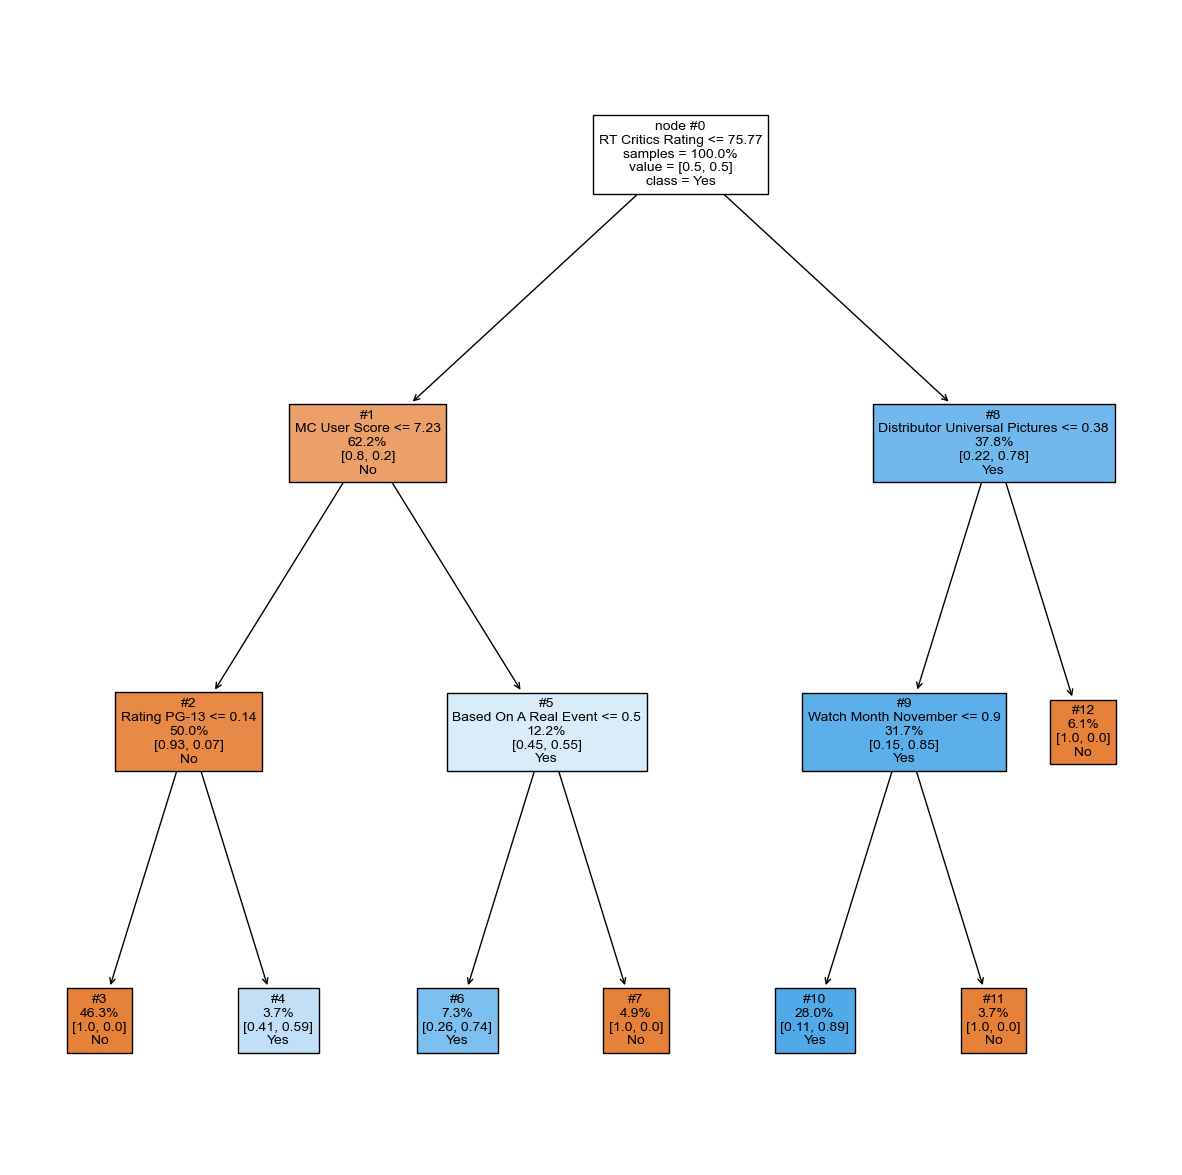

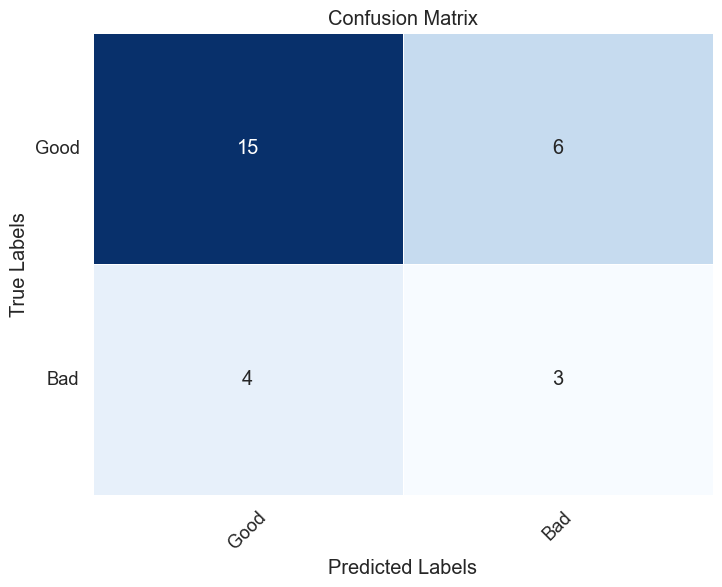

In [25]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Define function to train the model
def train_model(d=3, cw='balanced', c='gini', s='random', msl=3):
    # Instantiate the Decision Tree classifier
    clf = DecisionTreeClassifier(max_depth=d,
                                 class_weight=cw,
                                 criterion=c,
                                 splitter=s,
                                 min_samples_leaf=msl)

    # Train the classifier
    clf.fit(x_train, y_train)

    # Plot the decision tree
    plt.figure(figsize=(15, 15))
    plot_tree(clf, feature_names=feature_cols, class_names=['No', 'Yes'], filled=True, precision=2, node_ids=True, fontsize=10, label='root', proportion=True, impurity=False)

    # Predict on the test set
    y_pred = clf.predict(x_test)

    # Print classification report
    print(metrics.classification_report(y_test, y_pred))
    
    # Predict probabilities
    probabilities = clf.predict_proba(x_test)[:, 1]

    return clf, probabilities

# Define function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, classes):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=np.flip(classes), yticklabels=np.flip(classes), linewidths=.5)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

# Train the model
trained_model, probabilities = train_model()

# Plot confusion matrix
classes = ['Bad', 'Good']
conf_matrix = metrics.confusion_matrix(y_test, trained_model.predict(x_test))
plot_confusion_matrix(conf_matrix, classes)

In [26]:
# Find the index of the movie with the highest predicted probability of being perfect
perfect_movie_index = np.argmax(probabilities)

# Extract details of the movie with the highest predicted probability
perfect_movie_details = movie2.iloc[perfect_movie_index]

# Drop the target columns from the perfect movie details
perfect_movie_details = perfect_movie_details.drop(['Target No', 'Target Yes'])

# Define a function to round float values to two decimal places
def round_float(x):
    if isinstance(x, float):
        return round(x, 2)
    else:
        return x

# Apply the rounding function to the perfect movie details
rounded_details = perfect_movie_details.apply(round_float)

# Print the rounded details of the perfect movie
print("The Perfect Movie Would Have These Stats:")
print(rounded_details)

The Perfect Movie Would Have These Stats:
Runtime                                                   142
Real Budget                                          25000000
Real Box Office                                      73300000
Real Profit                                          48300000
Inflated Budget                                      51357733
Inflated Box Office                                 150580873
Inflated Profit                                      99223140
ROI                                                         2
RT Critics Rating                                          91
RT Fan Rating                                              98
MC Critics Score                                           82
MC User Score                                               9
IMDB Rating                                                 9
Letterboxd Rating                                           4
Movie Age                                               10774
Movie Age At Watch          